In [35]:
import pandas as pd
import py2neo as pn
import time
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
neo4j_url = 'bolt://localhost:11003'
user = 'neo4j'
pwd = '0000'
# in advance, you have to manually change the active database with respect to the volume you want to query
# in neo4j.conf set dbms.memory.max_heap_size = 4G
data={}
# dictionary for dataframes to reduce the time of calculation
EntityIdAttributeNameDB='n.user_id'
# you have to change this according to how the attribute corresponding to entity identifier is called in your dataset

In [3]:
def timing(EntityLabel,TimeUnit,IntervalStartUnit=None,IntervalEndUnit=None,RelationshipType=None,EntityIdentifier=None,show_distribution=True):

    time_start = time.time()
    DegreeCentrality(EntityLabel,TimeUnit,IntervalStartUnit=IntervalStartUnit,IntervalEndUnit=IntervalEndUnit,RelationshipType=RelationshipType,EntityIdentifier=EntityIdentifier,show_distribution=show_distribution)
    time_end = time.time()
    time_c = time_end - time_start
    print('time cost', time_c, 's')

In [4]:
def conn():
    # connect DB
    try:
        return pn.Graph(neo4j_url,auth=(user, pwd))
    except Exception as error:
        print('Caught this error: ' + repr(error))

In [5]:
def GetTimeline(graph,EntityLabel):
    # query for timeline of entities with given label
    query_max_min = f"MATCH (n: {EntityLabel})" +\
                " RETURN min(n.startvalidtime) as min, max(n.endvalidtime) as max"
    return graph.run(query_max_min).to_data_frame()

In [6]:
def SplitTimeline(TimeUnit,result_min_max=None,IntervalStartUnit = None, IntervalEndUnit = None):
    if (IntervalStartUnit is None) & (IntervalEndUnit is None):
        tmin = result_min_max["min"][0]
        tmax = result_min_max["max"][0]
        # split the timeline with given time unit
        return pd.date_range(tmin, tmax, freq=TimeUnit)
    else:
        start_interval_datetime = pd.to_datetime(IntervalStartUnit)
        end_interval_datetime = pd.to_datetime(IntervalEndUnit)
        end_interval_end_datetime = end_interval_datetime + pd.Timedelta(days=1)
        return pd.date_range(start_interval_datetime, end_interval_end_datetime, freq=TimeUnit)

In [7]:
def DegreeInUnit(graph, UnitStartTime, UnitEndTime, EntityLabel, RelationshipTypeStr=None):
    # query for degree in one unit, maybe with relationships chosen
    query_degree = f"""MATCH (n:{EntityLabel}){"-" + f"[r:{RelationshipTypeStr}]" if RelationshipTypeStr else "-[r]"}-() WHERE datetime(r.endvalidtime) >= datetime('{UnitStartTime}') AND datetime(r.startvalidtime) < datetime('{UnitEndTime}') RETURN {EntityIdAttributeNameDB} AS EntityId, count(r) AS DegreeEntity"""
    print(query_degree)
    return graph.run(query_degree).to_data_frame()

In [15]:
def DegreeOnTimeline(graph, EntityLabel, TimeUnit, IntervalStartUnit = None, IntervalEndUnit = None, RelationshipType=None):

    def fill_empty_query(EntityDegree_df, time_axis) :
        for i in range(len(time_axis) - 1):
            if datetime.datetime.isoformat(time_axis[i]) not in EntityDegree_df.columns:
                EntityDegree_df[datetime.datetime.isoformat(time_axis[i])]=0
    # create the list of time units on the timeline
    if (IntervalStartUnit is None) & (IntervalEndUnit is None):
        time_axis = SplitTimeline(TimeUnit,result_min_max=GetTimeline(graph, EntityLabel))
    else :
        time_axis = SplitTimeline(TimeUnit,IntervalStartUnit = IntervalStartUnit, IntervalEndUnit = IntervalEndUnit)
    EntityDegree=[]
    # if there is no restriction on relationship type
    if RelationshipType is None:
        # calculate degree centrality for every entity in every unit
        for i in range(0,len(time_axis)-1):
            t = datetime.datetime.isoformat(time_axis[i])
            try:
                # try to find required dataframe from the dictionary
                result_query_degree=data[f'{EntityLabel}_{TimeUnit}'].loc[:,str(t)]
            except:
                t_after = datetime.datetime.isoformat(time_axis[i+1])
                result_query_degree = DegreeInUnit(graph, t, t_after, EntityLabel)
                 # to avoid error when in one time unit there is no relationship and the step above returns nothing
                try:
                    result_query_degree.set_index('EntityId',inplace=True)
                    result_query_degree.columns=[str(t)]
                except:
                    continue
                try:
                    data[f'{EntityLabel}_{TimeUnit}'] = pd.concat([data[f'{EntityLabel}_{TimeUnit}'], result_query_degree], axis=1)
                except:
                    data[f'{EntityLabel}_{TimeUnit}'] = result_query_degree
            # collect result
            EntityDegree.append(result_query_degree)
        data[f'{EntityLabel}_{TimeUnit}'].fillna(0,inplace=True)
        fill_empty_query(data[f'{EntityLabel}_{TimeUnit}'],time_axis)
    # if there is a selection on relationship type
    else:
        # unify the order of relationship names
        RelationshipType.sort()
        # transform them to string with the separator for Neo4j CQL
        RelationshipTypeStr='|'.join(RelationshipType)

        for i in range(0,len(time_axis)-1):
            # calculate degree centrality for every entity in every unit
            t = datetime.datetime.isoformat(time_axis[i])
            try:
                # try to find required dataframe from the dictionary
                result_query_degree=data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'].loc[:,str(t)]
            except:
                t = datetime.datetime.isoformat(time_axis[i])
                t_after = datetime.datetime.isoformat(time_axis[i+1])
                result_query_degree = DegreeInUnit(graph, t, t_after, EntityLabel, RelationshipTypeStr)
                # to avoid error when in one time unit there is no relationship and the step above returns nothing
                try:
                    result_query_degree.set_index('EntityId',inplace=True)
                    result_query_degree.columns=[str(t)]
                except:
                    continue
                try:
                    data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'] = pd.concat([data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'], result_query_degree], axis=1)
                except:
                    data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'] = result_query_degree
            EntityDegree.append(result_query_degree)
        data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'].fillna(0,inplace=True)
        fill_empty_query(data[f'{EntityLabel}_{TimeUnit}_{RelationshipTypeStr}'],time_axis)
    EntityDegree_df=pd.concat(EntityDegree, axis=1)
    EntityDegree_df.fillna(0,inplace=True)
    fill_empty_query(EntityDegree_df,time_axis)
    return EntityDegree_df

In [16]:
def DegreeOfInterval(DataFrame,IntervalStartUnit,IntervalEndUnit,EntityIdentifier):
    # calculate degree centrality of one entity in a time interval chosen
    return DataFrame.loc[EntityIdentifier,IntervalStartUnit:IntervalEndUnit].mean()

In [17]:
def Position(EntitiesDegree, EntityIdentifier=None, show_distribution=True):
    # if it is not specially for an entity
    if EntityIdentifier is None:
        # show degree centrality of every entity with the label chosen and their distribution
        EntitiesDegree.columns=['Degree']
        EntitiesDegree=EntitiesDegree.sort_values(by='Degree',ascending=False)
        EntitiesDegree['Rank']=range(1,EntitiesDegree.shape[0]+1)
        if show_distribution :
            EntitiesDegree['Degree'].plot(kind='box')
            EntitiesDegree['Position']=EntitiesDegree['Rank']/EntitiesDegree.shape[0]
        print(EntitiesDegree)
    # if it is not for a special time interval
    else:
        # show degree centrality of chosen entity with its rank and position among all entities with the same label
        EntitiesDegree.columns=['Degree']
        EntitiesDegree=EntitiesDegree.sort_values(by='Degree',ascending=False)
        EntitiesDegree['Rank']=range(1,EntitiesDegree.shape[0]+1)
        if show_distribution :
            EntitiesDegree['Degree'].plot(kind='box')
            plt.axhline(y=EntitiesDegree.loc[EntityIdentifier].iloc[0],ls='--',label='Entity')
            plt.legend()
            plt.show(block=False)
            EntitiesDegree['Position']=EntitiesDegree['Rank']/EntitiesDegree.shape[0]
        print(EntitiesDegree.loc[EntityIdentifier])

In [18]:
def Evolution(DegreeInEveryUnit, EntityIdentifier):
        # show degree evolution of an entity in its valid time
        DegreeInEveryUnit.loc[EntityIdentifier].plot()

In [19]:
def DegreeCentrality(EntityLabel,TimeUnit,IntervalStartUnit=None,IntervalEndUnit=None,RelationshipType=None,EntityIdentifier=None,show_distribution=True):
    """
    Calculates the degree centrality of entities over time and returns the results in various formats.

    Parameters:
    EntityLabel (str): The label of the entity to analyze.
    TimeUnit (str): The time unit to use for analysis (e.g. 'm' for month, 'w' for week, 'd' for day).
    RelationshipType (list of str, optional): The types of relationships to consider in analysis. If not specified, all relationship types will be considered.
    EntityIdentifier (str, optional): The identifier of a specific entity to analyze. If not specified, the distribution of degree centrality across all entities will be shown.
    IntervalStartUnit (str, optional): The start time unit of a time interval to analyze (inclusive).
    IntervalEndUnit (str, optional): The end time unit of a time interval to analyze (inclusive).
    show_distribution (bool, optional): Whether to show a plot of the degree distribution across entities.

    Returns:
    None
    """

    # connect to database
    graph=conn()

    df=DegreeOnTimeline(graph, EntityLabel, TimeUnit, IntervalStartUnit, IntervalEndUnit, RelationshipType)

    # if it is not specially for an entity
    if EntityIdentifier is None:
        # show the distribution curve and degree table
        Position(pd.DataFrame(df.mean(axis=1)),show_distribution=show_distribution)
    # if it is not for a special time interval
    else :
        # show the distribution curve and the position of the entity
        Position(pd.DataFrame(df.mean(axis=1)),EntityIdentifier,show_distribution=show_distribution)
        # show degree evolution of an entity in its valid time
        Evolution(df, EntityIdentifier)

In [42]:
DegreeCentrality('Student','d',RelationshipType=['SendSMS'],show_distribution=False)

MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SendSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-13T00:00:00') AND datetime(r.startvalid

In [43]:
DegreeCentrality('Student','d',RelationshipType=['ReceiveSMS'],show_distribution=False)

MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:ReceiveSMS]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-13T00:00:00') AND dateti

In [44]:
DegreeCentrality('Student','d',RelationshipType=['Call'],show_distribution=False)

MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:Call]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-13T00:00:00') AND datetime(r.startvalidtime) < datetim

In [45]:
DegreeCentrality('Student','d',RelationshipType=['SocializeTwicePerWeek'],show_distribution=False)

MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:SocializeTwicePerWeek]-() WHERE datetime(r.endv

In [46]:
DegreeCentrality('Student', 'd', RelationshipType=['PoliticalDiscussant'], show_distribution=False,)

MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:PoliticalDiscussant]-() WHERE datetime(r.endvalidtime) 

In [47]:
DegreeCentrality('Student', 'd', RelationshipType=['FacebookAllTaggedPhotos'], show_distribution=False,)

MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:FacebookAllTaggedPhotos]-() WHERE datet

In [48]:
DegreeCentrality('Student', 'd', RelationshipType=['BlogLivejournalTwitter'], show_distribution=False)

MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:BlogLivejournalTwitter]-() WHERE datetime(r

In [49]:
DegreeCentrality('Student', 'd', RelationshipType=['CloseFriend'], show_distribution=False)

MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-09T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-10T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-10T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-11T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-11T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-12T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-12T00:00:00') AND datetime(r.startvalidtime) < datetime('2009-01-13T00:00:00') RETURN n.user_id AS EntityId, count(r) AS DegreeEntity
MATCH (n:Student)-[r:CloseFriend]-() WHERE datetime(r.endvalidtime) >= datetime('2009-01-13T00:00:00') AND d

In [50]:
data

{'Student_d_SendSMS':           2009-03-08T00:00:00  2009-03-09T00:00:00  2009-03-05T00:00:00  \
 EntityId                                                                  
 60                        1.0                  0.0                  0.0   
 30                        1.0                  0.0                  0.0   
 24                        0.0                  1.0                  0.0   
 58                        0.0                  1.0                  0.0   
 4                         0.0                  0.0                  0.0   
 7                         0.0                  0.0                  0.0   
 52                        0.0                  0.0                  0.0   
 64                        0.0                  0.0                  0.0   
 43                        0.0                  0.0                  0.0   
 26                        0.0                  0.0                  0.0   
 65                        0.0                  0.0                

In [51]:
data.keys()

dict_keys(['Student_d_SendSMS', 'Student_d_ReceiveSMS', 'Student_d_Call', 'Student_d_SocializeTwicePerWeek', 'Student_d_PoliticalDiscussant', 'Student_d_FacebookAllTaggedPhotos', 'Student_d_BlogLivejournalTwitter', 'Student_d_CloseFriend'])

In [52]:
data_degree = {}
data_degree_list=[]
for key, df in data.items():
    new_df = pd.DataFrame(df.mean(axis=1))
    new_df.columns=['Degree']
    new_df = new_df.sort_values('Degree', ascending=False)
    new_df.rename(columns=lambda x: x.replace('Degree', key+'_Degree'), inplace=True)
    new_df.rename(columns=lambda x: x.replace('Student_d_', ''), inplace=True)
    data_degree_list.append(new_df.copy())
    new_df['Rank'] = range(1, len(new_df) + 1)
    data_degree[key] = new_df

In [53]:
data_degree

{'Student_d_SendSMS':           SendSMS_Degree  Rank
 EntityId                      
 24              1.584906     1
 58              0.962264     2
 31              0.603774     3
 7               0.490566     4
 4               0.386792     5
 52              0.254717     6
 57              0.122642     7
 56              0.103774     8
 43              0.066038     9
 64              0.066038    10
 30              0.056604    11
 21              0.056604    12
 27              0.047170    13
 20              0.037736    14
 48              0.028302    15
 15              0.028302    16
 67              0.018868    17
 51              0.018868    18
 22              0.009434    19
 60              0.009434    20
 65              0.009434    21
 26              0.009434    22
 36              0.009434    23,
 'Student_d_ReceiveSMS':           ReceiveSMS_Degree  Rank
 EntityId                         
 24                 3.207547     1
 58                 2.632075     2
 31           

In [54]:
degree_df = pd.concat(data_degree_list, axis=1)
degree_df.rename(columns=lambda x: x.replace('_Degree', ''), inplace=True)
degree_df.fillna(0,inplace=True)

In [55]:
degree_df

SendSMS  ReceiveSMS      Call  SocializeTwicePerWeek  \
EntityId                                                          
24        1.584906    3.207547  3.886792               0.358491   
58        0.962264    2.632075  3.594340               0.377358   
31        0.603774    0.594340  0.490566               0.386792   
7         0.490566    0.528302  4.867925               0.235849   
4         0.386792    0.500000  5.358491               0.433962   
...            ...         ...       ...                    ...   
34        0.000000    0.000000  0.009434               0.216981   
78        0.000000    0.000000  0.000000               0.490566   
49        0.000000    0.000000  0.000000               0.179245   
37        0.000000    0.000000  0.000000               0.028302   
61        0.000000    0.000000  0.000000               0.000000   

          PoliticalDiscussant  FacebookAllTaggedPhotos  \
EntityId                                                 
24                   0.292453                 0.509434   
58                   0.339623                 0.509434   
31                   0.339623                 0.537736   
7                    0.160377                 0.500000   
4                    0.367925                 0.603774   
...                       ...                      ...   
34                   0.160377                 0.320755   
78                   0.358491                 0.773585   
49                   0.103774                 0.358491   
37                   0.160377                 1.018868   
61                   0.000000                 0.150943   

          BlogLivejournalTwitter  CloseFriend  
EntityId                                       
24                      0.500000     0.216981  
58                      0.509434     0.160377  
31                      0.547170     0.320755  
7                       0.509434     0.103774  
4                       0.537736     0.207547  
...                          ...          ...  
34                      0.311321     0.122642  
78                      0.603774     0.169811  
49                      0.367925     0.084906  
37                      1.415094     0.037736  
61                      0.160377     0.000000  

[65 rows x 8 columns]

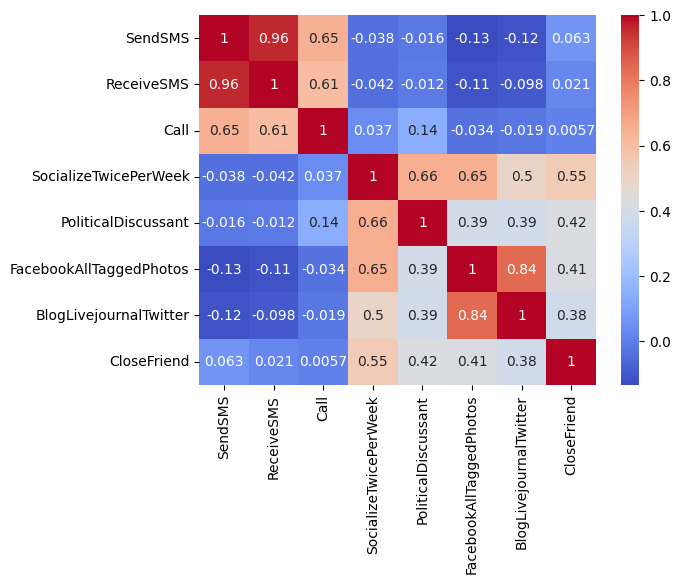

In [56]:
sns.heatmap(degree_df.corr(), cmap='coolwarm', annot=True)
plt.savefig('heatmap.pdf', bbox_inches='tight', format='pdf')
plt.show()